In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Math, display
from matplotlib import cm
from pydrake.all import (CommonSolverOption, MakeVectorVariable, ToLatex,
                         MathematicalProgram, Polynomial, Solve, SolverOptions,
                         Variable, Variables)

plt.rcParams.update({"savefig.transparent": True})


<IPython.core.display.Math object>

<IPython.core.display.Math object>

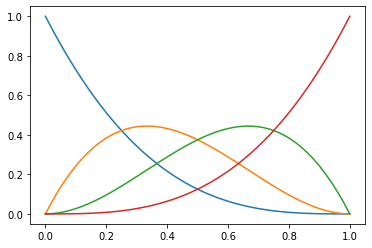

In [2]:

def BezierCurve(t, x):
    if len(x) == 1:
        return x[0]
    return (1-t)*BezierCurve(t, x[:-1]) + t*BezierCurve(t, x[1:])

t = Variable('t')
x = MakeVectorVariable(4, 'x')
b = BezierCurve(t, x)
display(Math(ToLatex(b)))
display(Math(ToLatex(b.Expand())))

fig, ax = plt.subplots()
N = 4
ts = np.linspace(0, 1, 51)
for i in range(N):
    x = np.zeros(N)
    x[i] = 1
    ax.plot(ts, BezierCurve(ts, x))

<IPython.core.display.Math object>

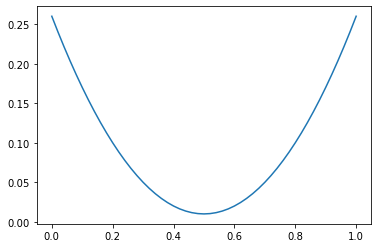

In [3]:
def BernsteinPolynomial(t, i, n):
    c = np.math.factorial(n) / (np.math.factorial(i) * np.math.factorial(n - i))
    return c * t**i * (1-t)**(n-i)

# a multi-dimensional Bezier surface in the variables x with degrees K.shape-1
# (and coefficients K).
def BezierSurface(x, K):
    assert len(x) == len(K.shape)
    it = np.nditer(K, flags=['multi_index', 'refs_ok'])
    p = 0
    for k in it:
        b = np.copy(k)
        for dim, idx in enumerate(it.multi_index):
            b *= BernsteinPolynomial(x[dim], idx, K.shape[dim]-1)
        p += b
    return p

t = Variable('t')
x = MakeVectorVariable(4, 'x')
b = BezierSurface([t], x)
display(Math(ToLatex(b.Expand())))

def fit_arbitrary_poly(p, extra_deg=0):
    prog = MathematicalProgram()
    num_coeffs = 1
    coeffs_shape = []
    vars = [v for v in p.indeterminates()]
    for v in p.indeterminates():
        d = p.Degree(v) + extra_deg
        num_coeffs *= d + 1
        coeffs_shape.append(d + 1)
    k = prog.NewContinuousVariables(num_coeffs)
    b = Polynomial(BezierSurface(vars, k.reshape(coeffs_shape)),
                   p.indeterminates())
    diff = p - b
    for monomial,coeff in diff.monomial_to_coefficient_map().items():
        #print(f'monomial: {monomial}, coef: {coeff}')
        prog.AddLinearEqualityConstraint(coeff, 0)
    result = Solve(prog)
    #print(result.is_success())
    #print(np.min(result.GetSolution(k)))

x = Variable('x')
u = Variable('u')
p = Polynomial(.01+(x-.5)**2, Variables([x]))
xs = np.linspace(0, 1, 51)
ps = [p.Evaluate({x: xi}) for xi in xs]
plt.plot(xs, ps)
# My control points get closer and closer to the values of the curve as I increase the (extra) degree.
for extra_deg in range(30): 
    fit_arbitrary_poly(p, extra_deg)


# Bezier Dynamic Programming

## Cubic polynomial optimal control

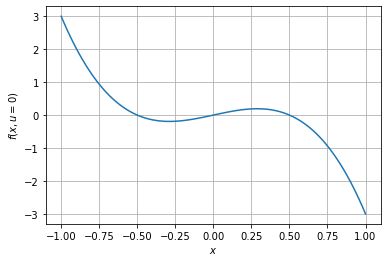

In [3]:
# Scalar dynamics.
f = lambda x, u : x - 4 * x ** 3 - u
# Quadratic running cost.
l = lambda x, u : x ** 2 + u ** 2
# Input limits.
U = [-1, 1]
# State limits (region of state space where we approximate the value function).
X = [-1, 1]

# Plot dynamics with zero input.
n_breaks = 101
x_breaks = np.linspace(*X, n_breaks)
plt.plot(x_breaks, f(x_breaks, np.zeros(n_breaks)))
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x, u=0)$')
plt.grid(True)

In [ ]:
# Given the degree for the approximate value function and the polynomials
# in the S procedure, solves the SOS and returns the approximate value function
# (together with the objective of the SOS program).
def sos_dp(deg, extra_deg):

    # Set up SOS program.
    prog = MathematicalProgram()
    x = Variable('x')
    u = Variable('u')
    # x \in [X[0], X[1]], x_scaled \in [0, 1]
    # x = (1-x_scaled)*X[0] + x_scaled*X[1]
    x_scaled = (x - X[0]) / (X[1] - X[0])
    u_scaled = (u - U[0]) / (U[1] - U[0])
    a = prog.NewContinuousVariables(deg+1, 'a')
    J = Polynomial(BezierCurve(x, a), Variables([x]))
    # J(0) = 0.
    prog.AddLinearConstraint(J.EvaluatePartial({x: 0}).ToExpression() == 0)
    #a = prog.NewContinuousVariables(1, 'a')[0]
    #J = Polynomial(a*x**2, Variables([x]))

    # Maximize volume beneath the value function.
    J_int = J.Integrate(x, 0, 1).ToExpression()
    prog.AddLinearCost(-J_int)

    xu = Variables([x,u])
    J_dot = J.Differentiate(x) * Polynomial(f(x, u), xu)

    p = J_dot + Polynomial(l(x,u), xu)
    num_coeffs = 1
    coeffs_shape = []
    for v in xu:
        d = p.Degree(v) + extra_deg
        num_coeffs *= d + 1
        coeffs_shape.append(d + 1)
    k = prog.NewContinuousVariables(num_coeffs,'k')
    prog.AddBoundingBoxConstraint(0, 1000, k)
    b = Polynomial(BezierSurface([x, u], k.reshape(coeffs_shape)), xu)
    diff = p - b
    for monomial,coeff in diff.monomial_to_coefficient_map().items():
        #display(Math(f'm = {ToLatex(monomial.ToExpression())}, c = {ToLatex(coeff)}'))
        prog.AddLinearEqualityConstraint(coeff, 0)

    # Solve and retrieve result.
    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintToConsole, 1)
    prog.SetSolverOptions(options)
    result = Solve(prog)
    print(result.get_solver_id().name())
    if not result.is_success():
        return None, None

    #    print(result.GetSolution(diff.ToExpression()))
    #print(f'p - b = {Polynomial(result.GetSolution(diff.ToExpression())).RemoveTermsWithSmallCoefficients(1e-6)}')
    #print(f'J(0) = {result.GetSolution(J.EvaluatePartial({x: 0}).ToExpression())}')
    #print(f'min(k) = {np.min(result.GetSolution(k))}')
    #print(result.get_solution_result())

    # retrieve value function
    J_opt_expr = result.GetSolution(J.ToExpression())
    print(f'J_opt = {J_opt_expr}')
    J_opt = lambda x_eval: J_opt_expr.Evaluate({x: x_eval})
    area = -result.get_optimal_cost()

    return J_opt, area

# Solve for increasing degree.
degrees = np.arange(1, 10, 2)
J = {deg: sos_dp(deg, 0) for deg in degrees}

x_breaks = np.linspace(0, 1, n_breaks)

# Plot solution.
fig = plt.figure()
for deg in degrees:
    if J[deg][0] is None:
        print(f'degree {deg} failed')
        continue
    label = f'Deg. {deg*2}'
    J_plot = [J[deg][0](xi) for xi in x_breaks]
    print(J_plot)
    plt.plot(x_breaks, J_plot, label=label)
    print(f'Degree {deg} area under curve = {J[deg][1]}')
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')
plt.title('Value-function lower bound')
plt.legend()
plt.grid(True)

plt.savefig('bezier_sos_cubic.png')
